In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools

In [3]:
df = pd.read_excel('Data/YS_EA.xlsx')
# orgainize data by setting ID as the index
df.sort_values(by = 'ID', inplace = True)
df.set_index(keys = 'ID', inplace = True)
# truncate datetime to year and month
df['Date_month'] = df.DT.dt.year.astype('str') + '-' + df.DT.dt.month.astype('str')
df['Date_month'] = pd.to_datetime(df['Date_month'])
# select columns containing useful data and rename columns 
df = df[['INSTR_NO', 'Date_month', 'R11','R12']]
df.rename(columns = {'R11' : 'Stress',
                    'R12' : 'Temp'},
         inplace =  True)
features = ['Stress', 'Temp']
# fill missing values 
values = {feature : df[feature].median() for feature in features}
df.fillna(value = values, inplace = True)

In [4]:
# Prepare dataset to separate into different sensors 
sensors = df.INSTR_NO.unique()
dict_sensor = {}
for sensor in sensors:
    dict_sensor[sensor] = df[df.INSTR_NO == sensor]
for key, value in dict_sensor.items():
    dict_sensor[key] = dict_sensor[key].drop(columns = 'INSTR_NO')

In [5]:
# plot function for ploting outliers 
# columns: differnt outlier detection algorithms
# rows: different features 
def plot_outliers(dict_def, row, col):
    plt.style.use('seaborn-darkgrid')
    plt.rcParams['font.family'] = "serif"
    fig, axes = plt.subplots(row , col, figsize = (col * 5, row * 7),
                            dpi= 80, facecolor='w', edgecolor='k')
    for (sensor, cat), ax in zip(list(itertools.product(dict_def.keys(), features)),
                                 axes.T.flat):
        df = dict_def[sensor]
        ax.scatter(df.loc[df.Outliers == 'Outliers', 'Date_month'], 
                                           df.loc[df.Outliers == 'Outliers', cat], 
                                           color = 'r', label = 'Outliers', s = 10, alpha = .5)
        ax.scatter(df.loc[df.Outliers == 'Normal', 'Date_month'], 
                                           df.loc[df.Outliers == 'Normal', cat], 
                                           color = 'g', label = 'Normal', s = 10, alpha = .5)
        ax.set_title(sensor + '-' + cat, fontsize=20)
        ax.set_xlabel('Date')
        ax.set_ylabel('Value')
    
    fig.legend(labels= ['Outliers', 'Normal'],  
               loc="right",  
               borderaxespad=0.1,    
               title="Legend Title") 
    fig.tight_layout(pad=3.0)

In [6]:
# find outliers by using the percent of outliers calculated by IQR and Isolation forest algorithm
from sklearn.ensemble import IsolationForest
dict_iso_iqr = {}

dict_iqr_inter = {}
for sensor, df_sen in dict_sensor.items():
    df_iqr_inter = df_sen.copy()
    df_iqr_inter['Outliers'] = 0
    for cat in features:
        q1, q3 = np.percentile(df_iqr_inter[cat], [25,75])
        iqr = q3 - q1
        iqrmax, iqrmin = q3 + 1.5 * iqr, q1 - 1.5 * iqr
        ser_cat = [1 if (i > iqrmax) | (i < iqrmin) else 0 for i in df_iqr_inter[cat]]
        df_iqr_inter['Outliers'] += ser_cat
    dict_iqr_inter['iqr_' + sensor] = df_iqr_inter
    
for sensor, df_sen in dict_sensor.items():
    iso = IsolationForest(
        contamination= dict_iqr_inter['iqr_' + sensor].Outliers.mean())
    yhat = iso.fit_predict(df_sen.drop(columns = 'Date_month'))
    dict_iso_iqr['iso_iqr_' + sensor] = df_sen.copy()
    dict_iso_iqr['iso_iqr_' + sensor]['Outliers'] = ['Outliers' if i == -1 else 'Normal' for i in yhat]

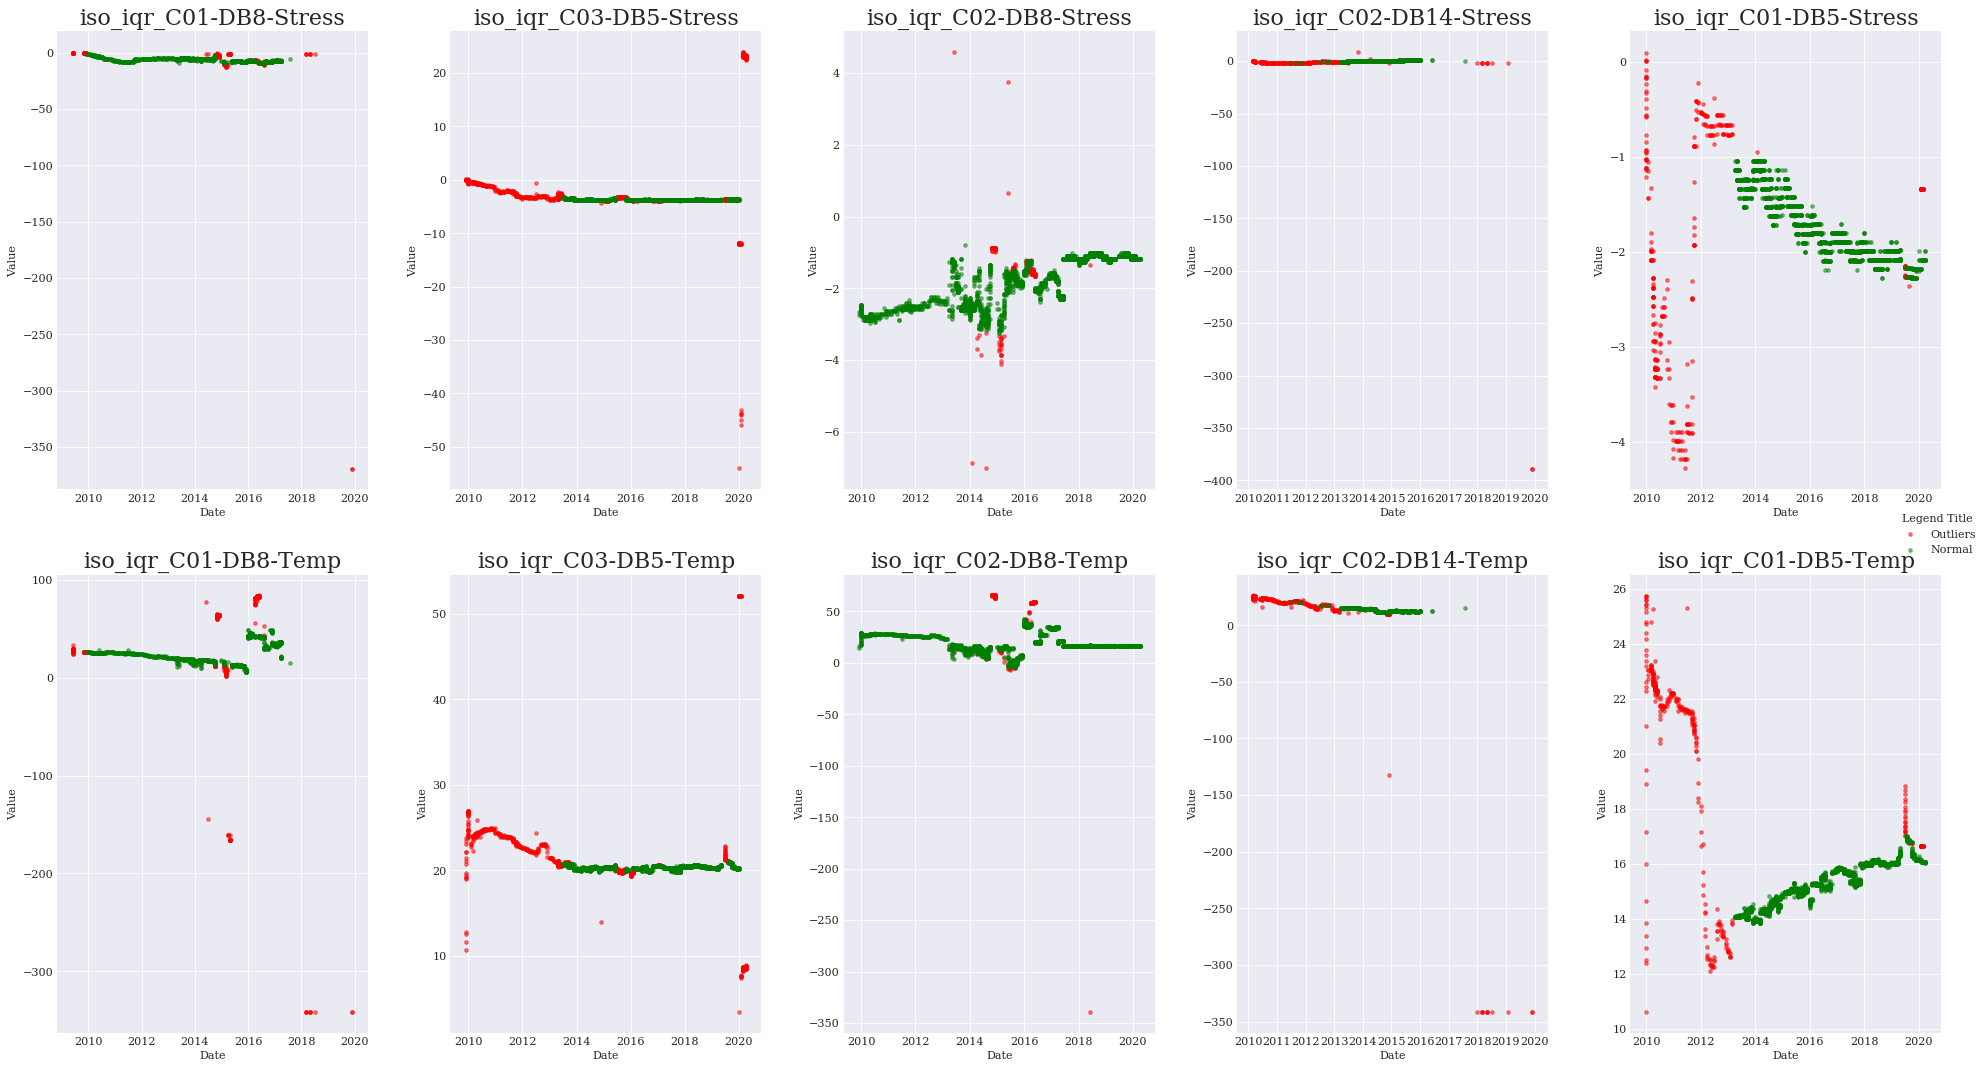

In [7]:
plot_outliers(dict_iso_iqr, row = math.ceil(len(dict_iso_iqr) / 5), col = 5)

In [9]:
df.INSTR_NO.unique()

array(['C01-DB8', 'C03-DB5', 'C02-DB8', 'C02-DB14', 'C01-DB5', 'C03-DB8',
       'C02-DB5', 'C01-DB14', 'C03-DB14'], dtype=object)

Reading with outliers


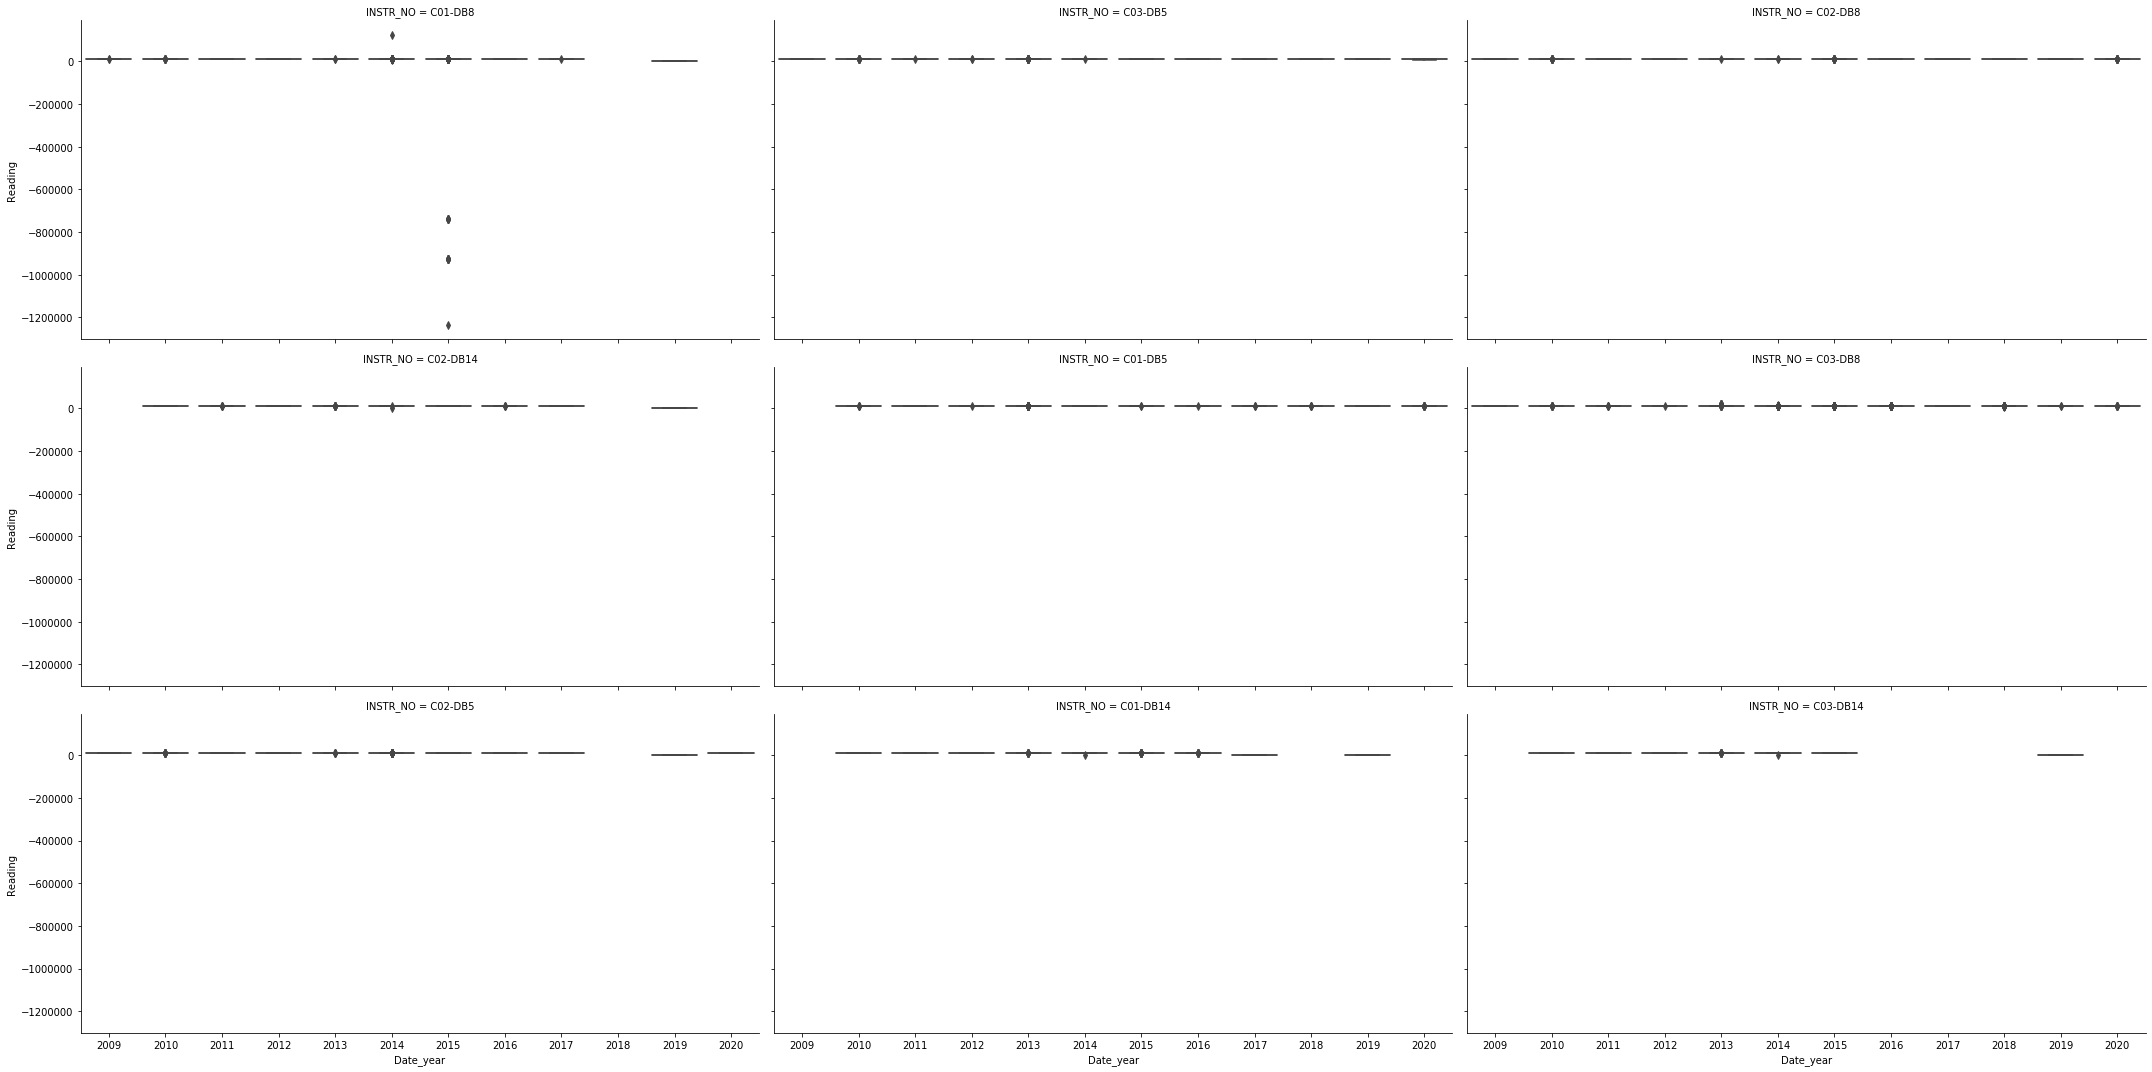

In [41]:
print('Reading with outliers')
g = sns.catplot(x = 'Date_year', y = 'Reading', col = 'INSTR_NO',col_wrap = 3, data = df,
            kind = 'box',
           height = 5, aspect = 2/1)
#g.set(ylim=(-30, 80))
# there seems to be three outliers in C01-D88 in 2015

Reading without outliers


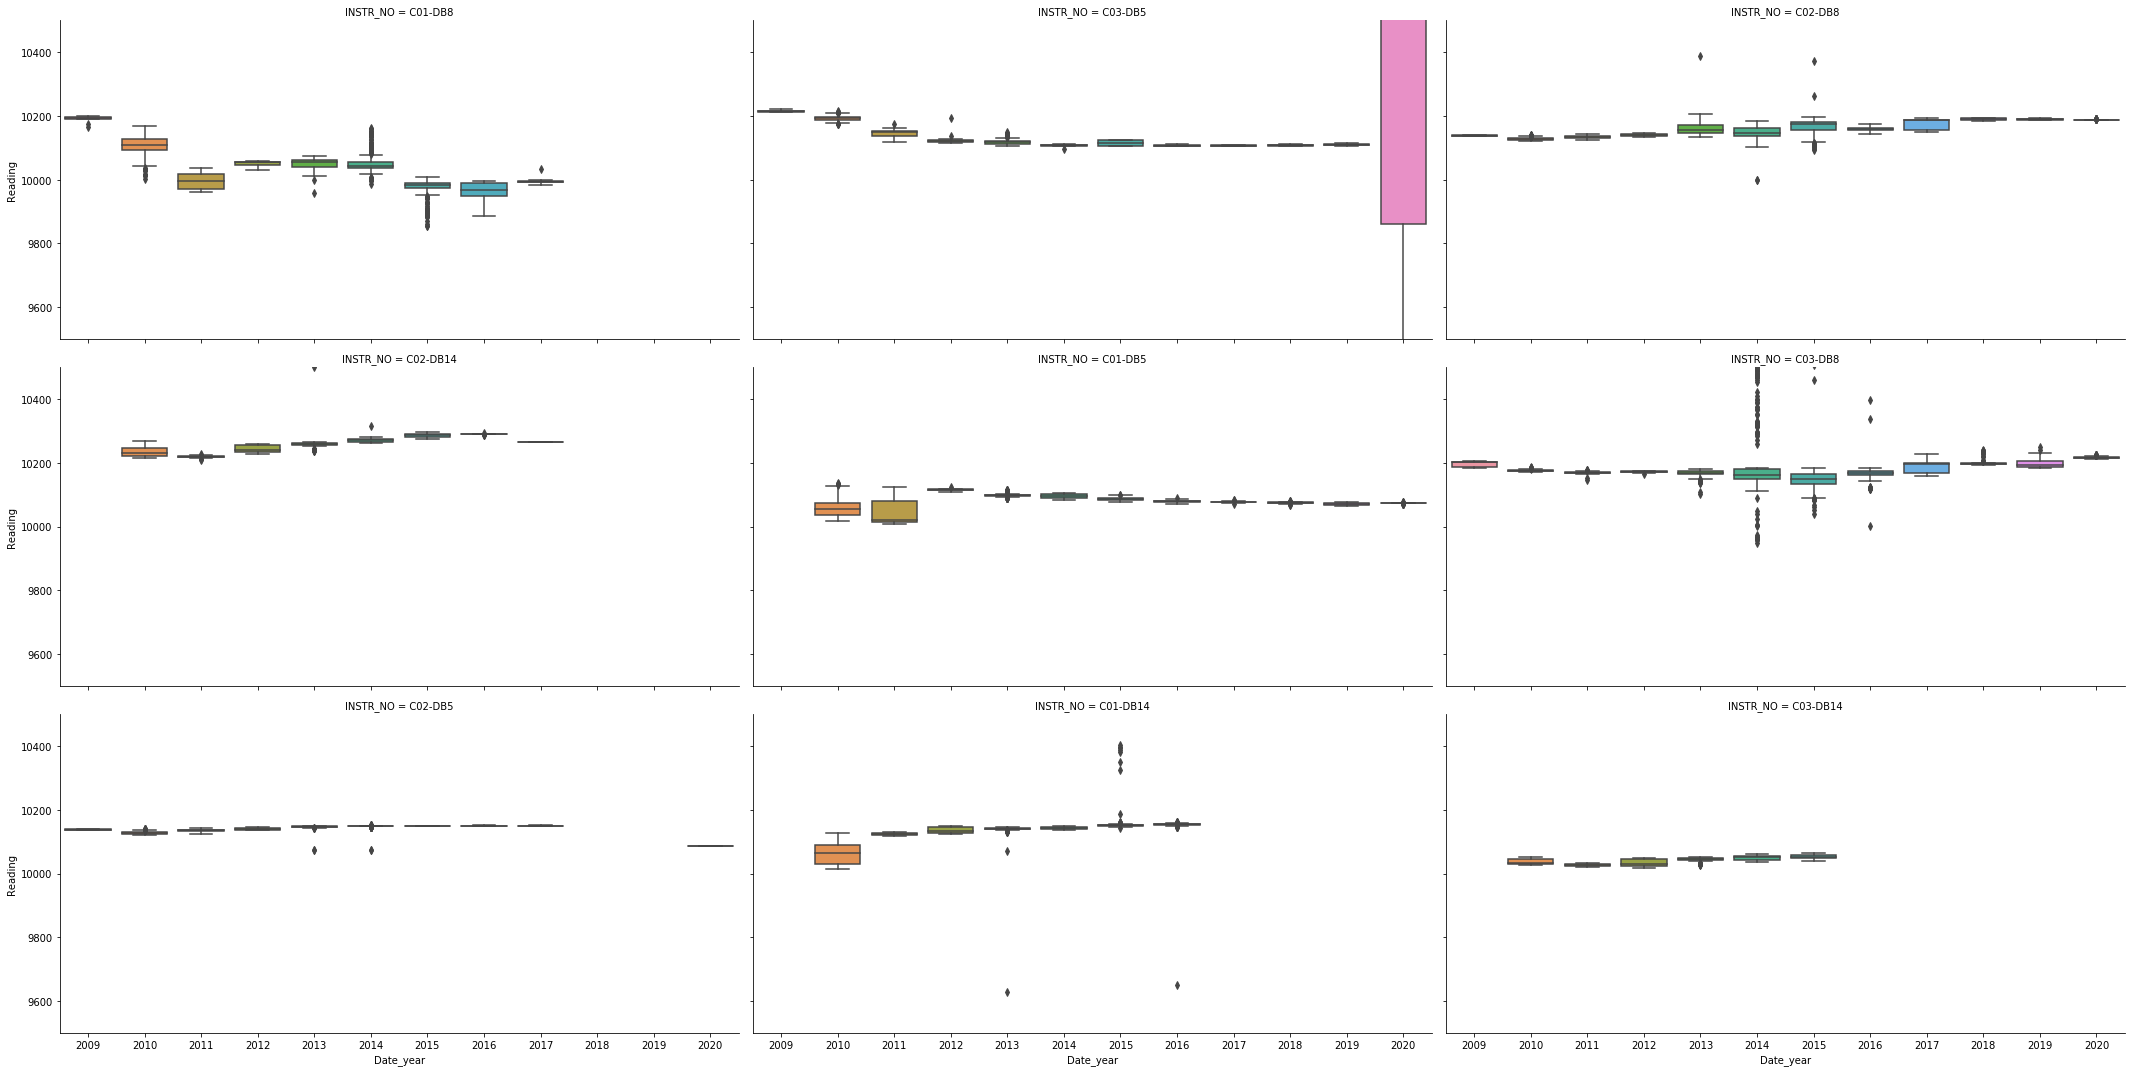

In [45]:
print('Reading without outliers')
g = sns.catplot(x = 'Date_year', y = 'Reading', col = 'INSTR_NO',col_wrap = 3, data = df,
            kind = 'box',
           height = 5, aspect = 2/1)
g.set(ylim=(9500, 10500))
# there are inconsistent measurements in several months for C01-D88, C02-DB14, C02-D85,C01-DB14, C03-DB14

Reading without outliers


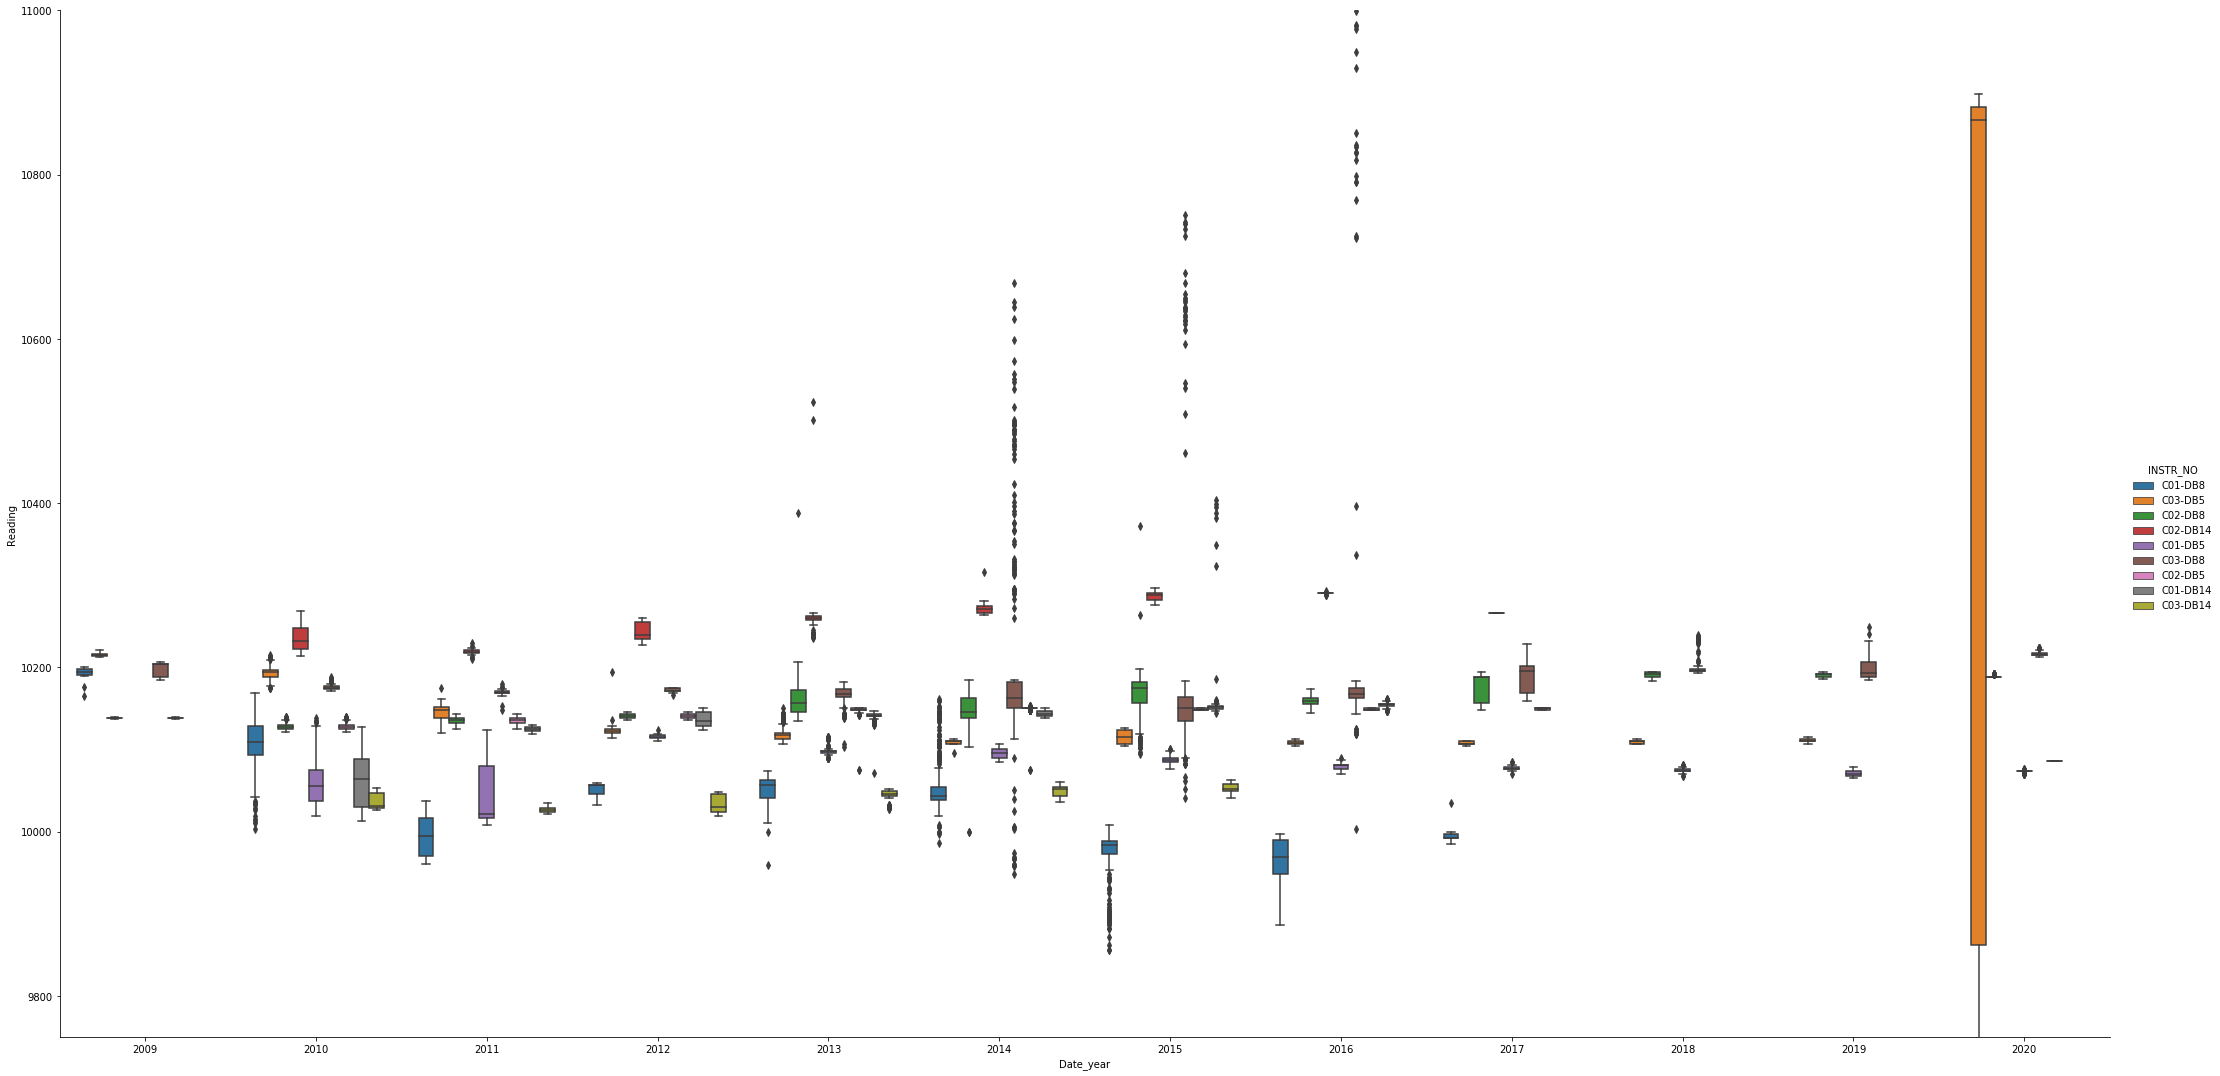

In [32]:
print('Reading without outliers')
g = sns.catplot(x = 'Date_year', y = 'Reading', hue = 'INSTR_NO', data = df,
            kind = 'box',
           height = 15, aspect = 2/1)
g.set(ylim=(9750, 11000))
# there are inconsistent measurements in several months for C01-D88, C02-DB14, C02-D85,C01-DB14, C03-DB14

Temprature Reading with outliers


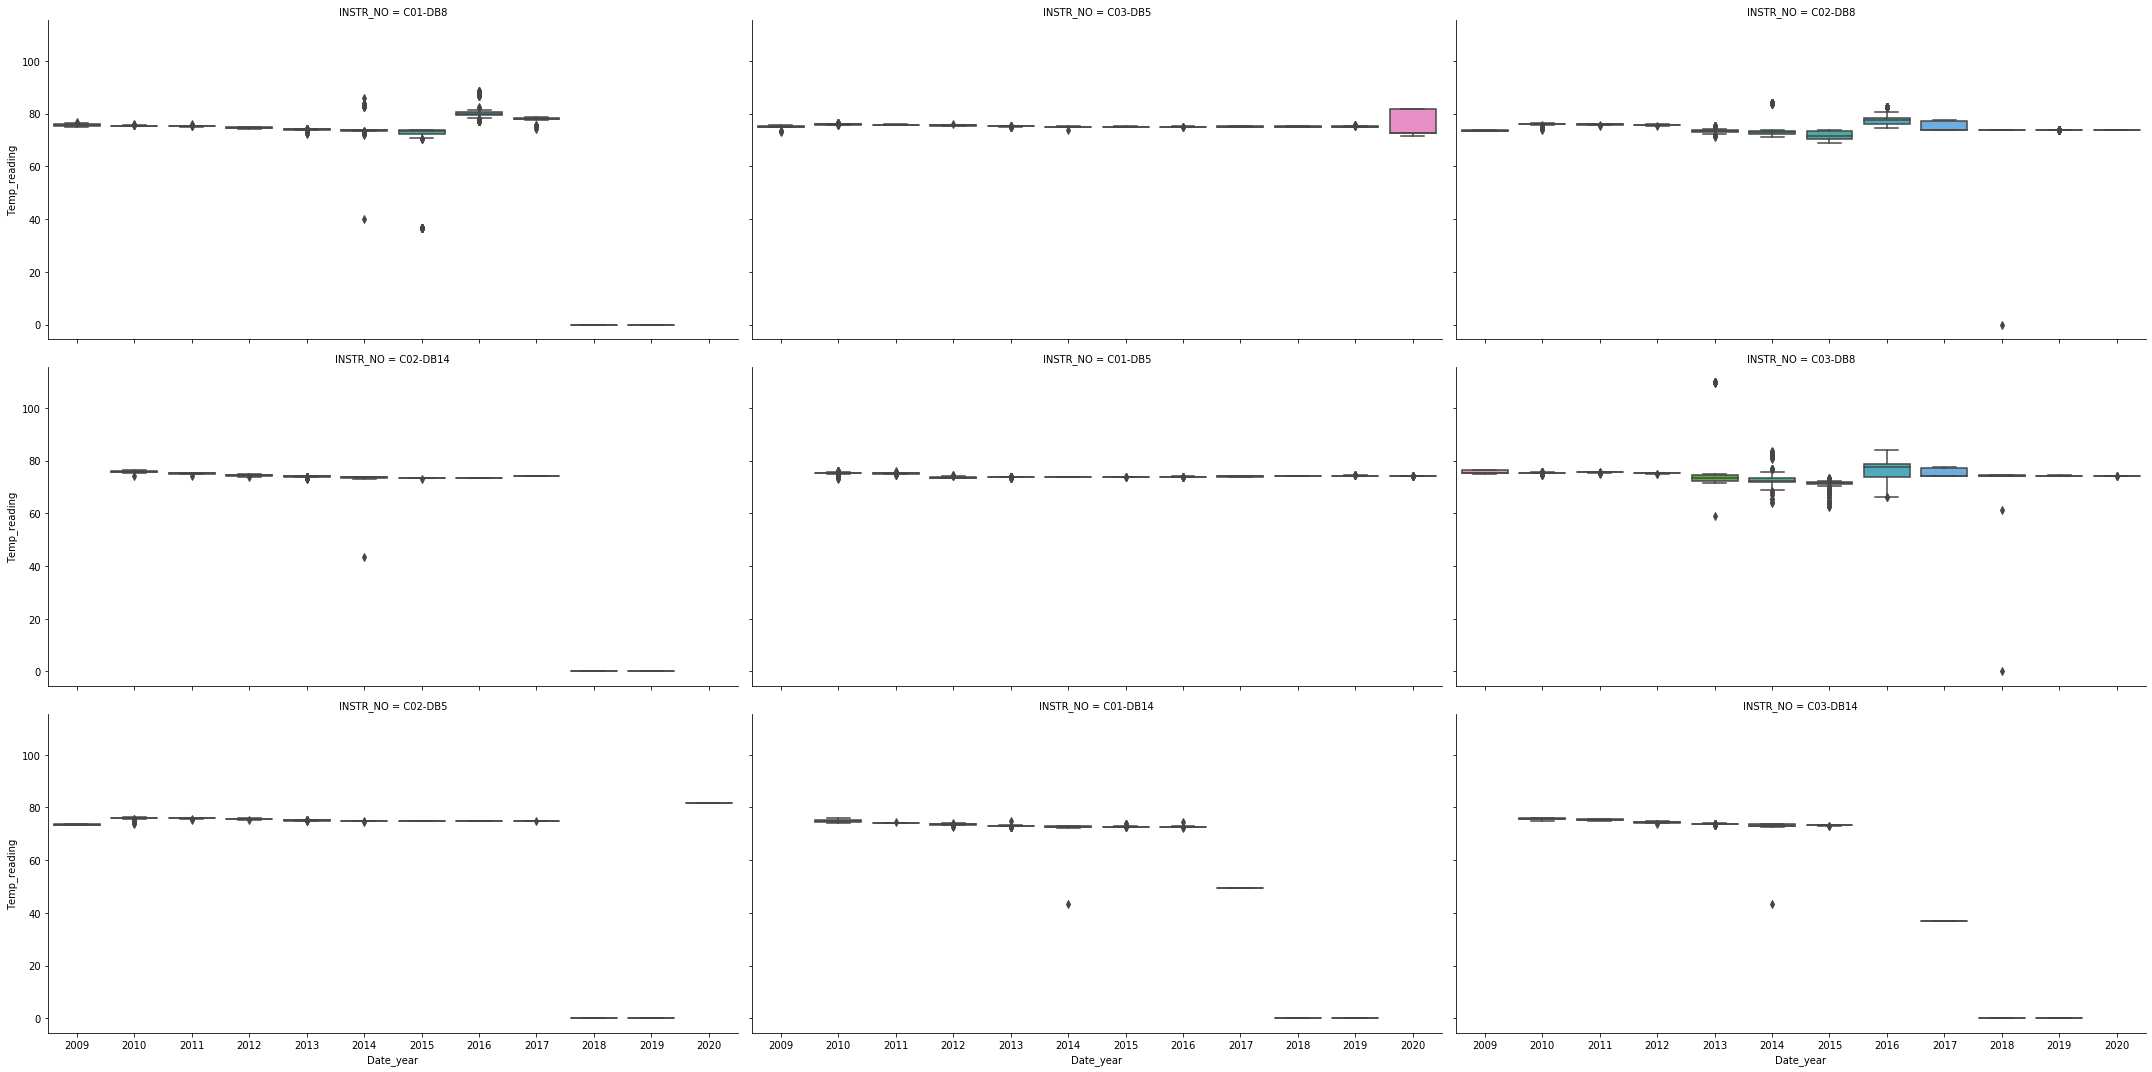

In [46]:
print('Temprature Reading with outliers')
g = sns.catplot(x = 'Date_year', y = 'Temp_reading', col = 'INSTR_NO',col_wrap = 3, data = df,
            kind = 'box',
           height = 5, aspect = 2/1)
# g.set(ylim=(60, 90))

Temprature Reading without outliers


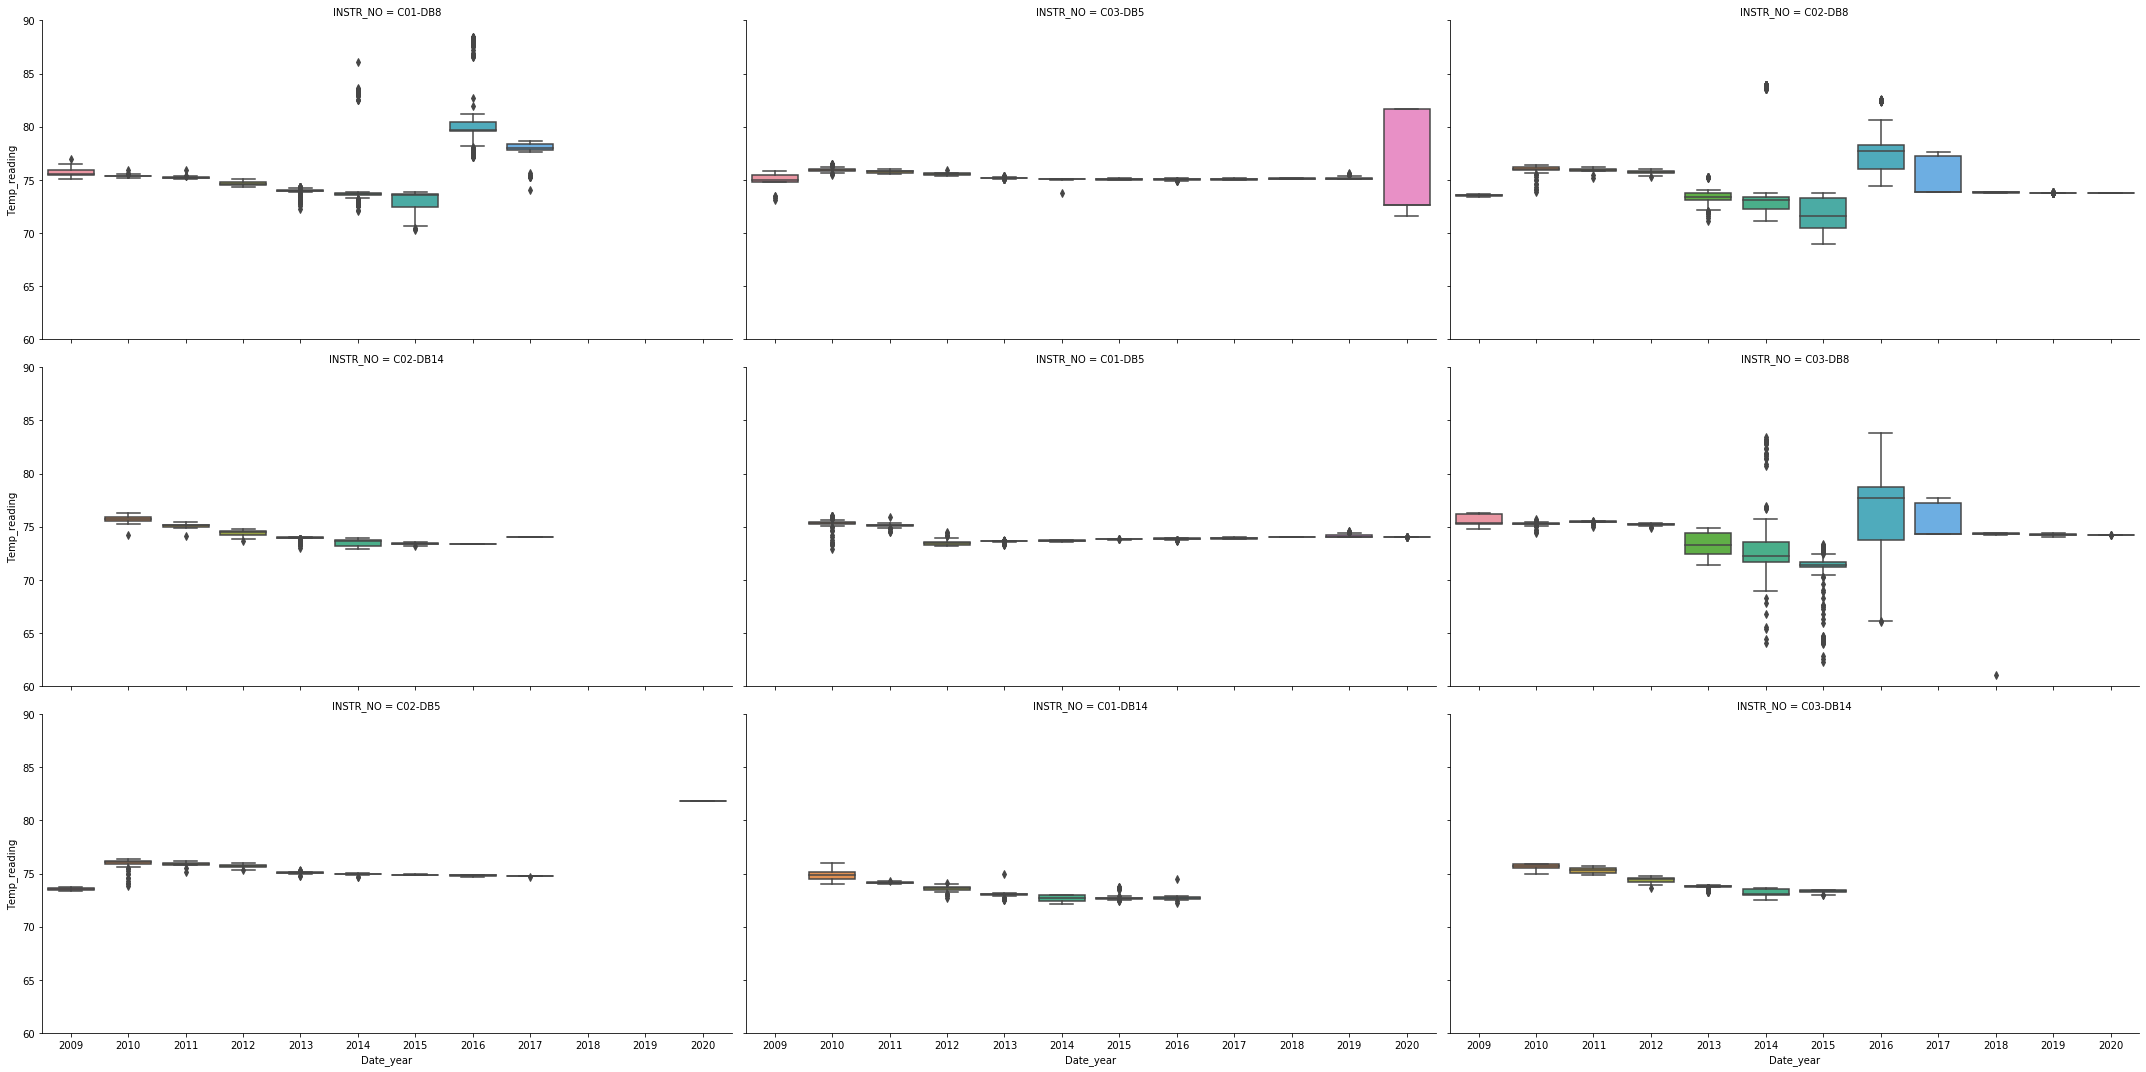

In [47]:
print('Temprature Reading without outliers')
g = sns.catplot(x = 'Date_year', y = 'Temp_reading', col = 'INSTR_NO',col_wrap = 3, data = df,
            kind = 'box',
           height = 5, aspect = 2/1)
g.set(ylim=(60, 90))

Stress with outliers


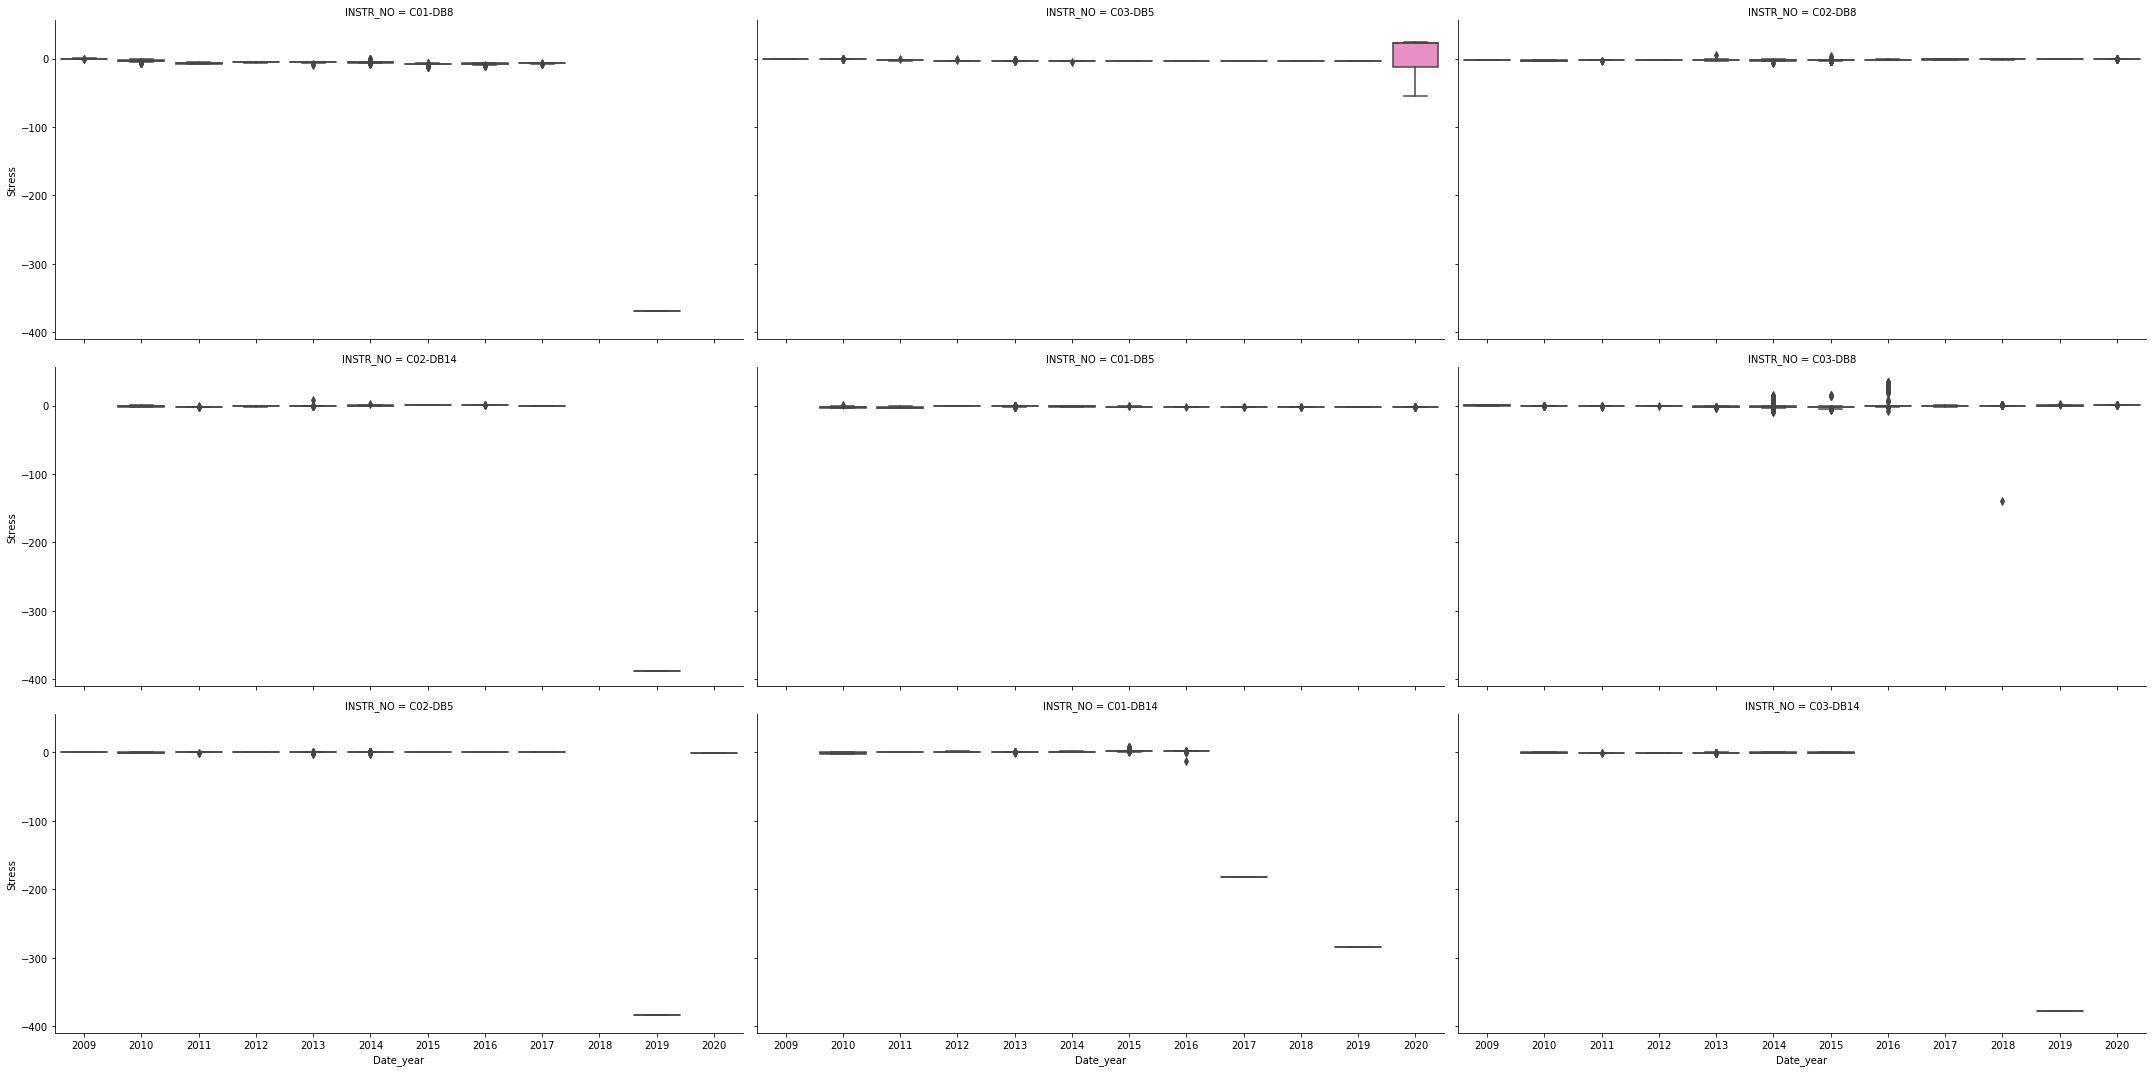

In [48]:
print('Stress with outliers')
g = sns.catplot(x = 'Date_year', y = 'Stress', col = 'INSTR_NO',col_wrap = 3, data = df,
            kind = 'box',
           height = 5, aspect = 2/1)
# g.set(ylim=(60, 90))

Stress without outliers


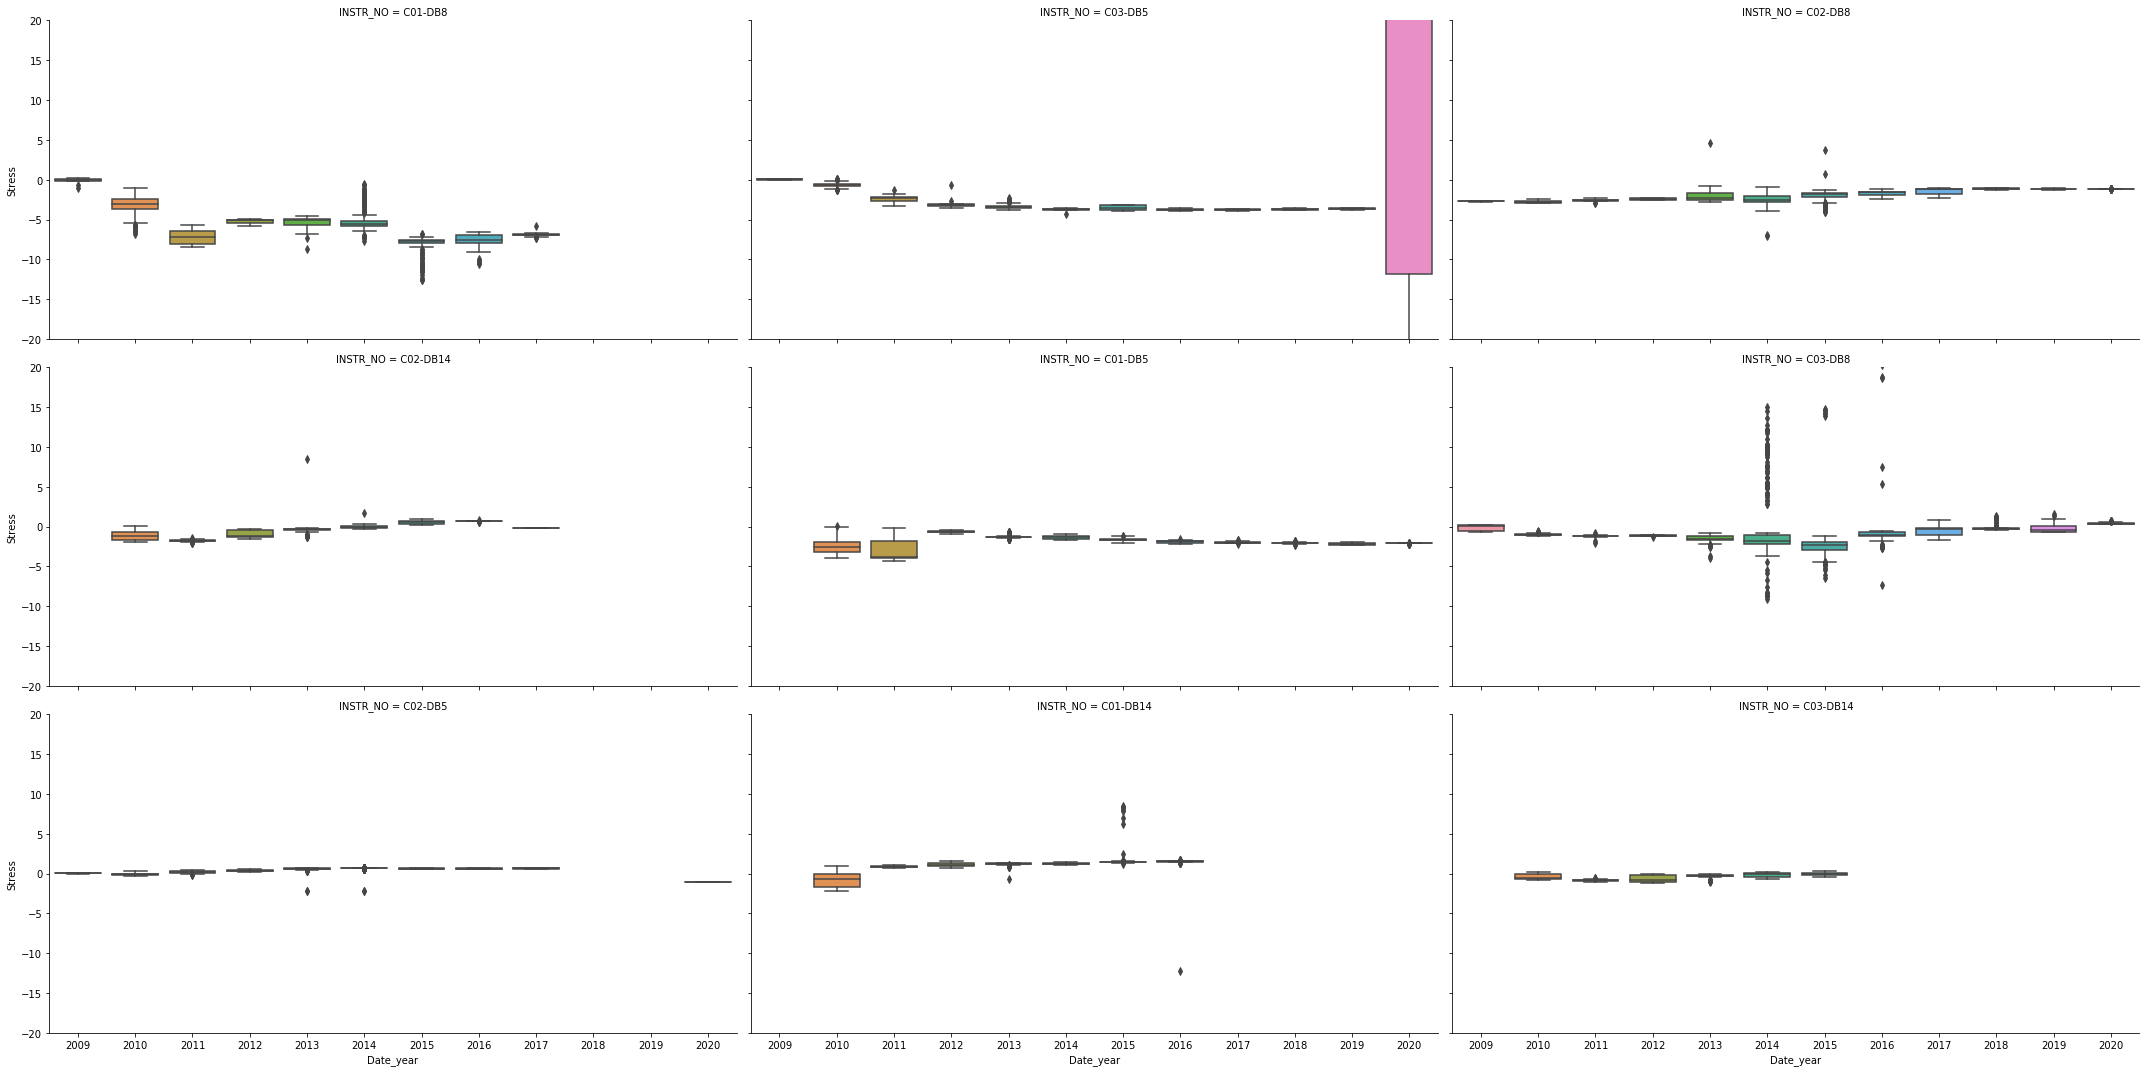

In [51]:
print('Stress without outliers')
g = sns.catplot(x = 'Date_year', y = 'Stress', col = 'INSTR_NO',col_wrap = 3, data = df,
            kind = 'box',
           height = 5, aspect = 2/1)
g.set(ylim=(-20, 20))

Temperature with outliers


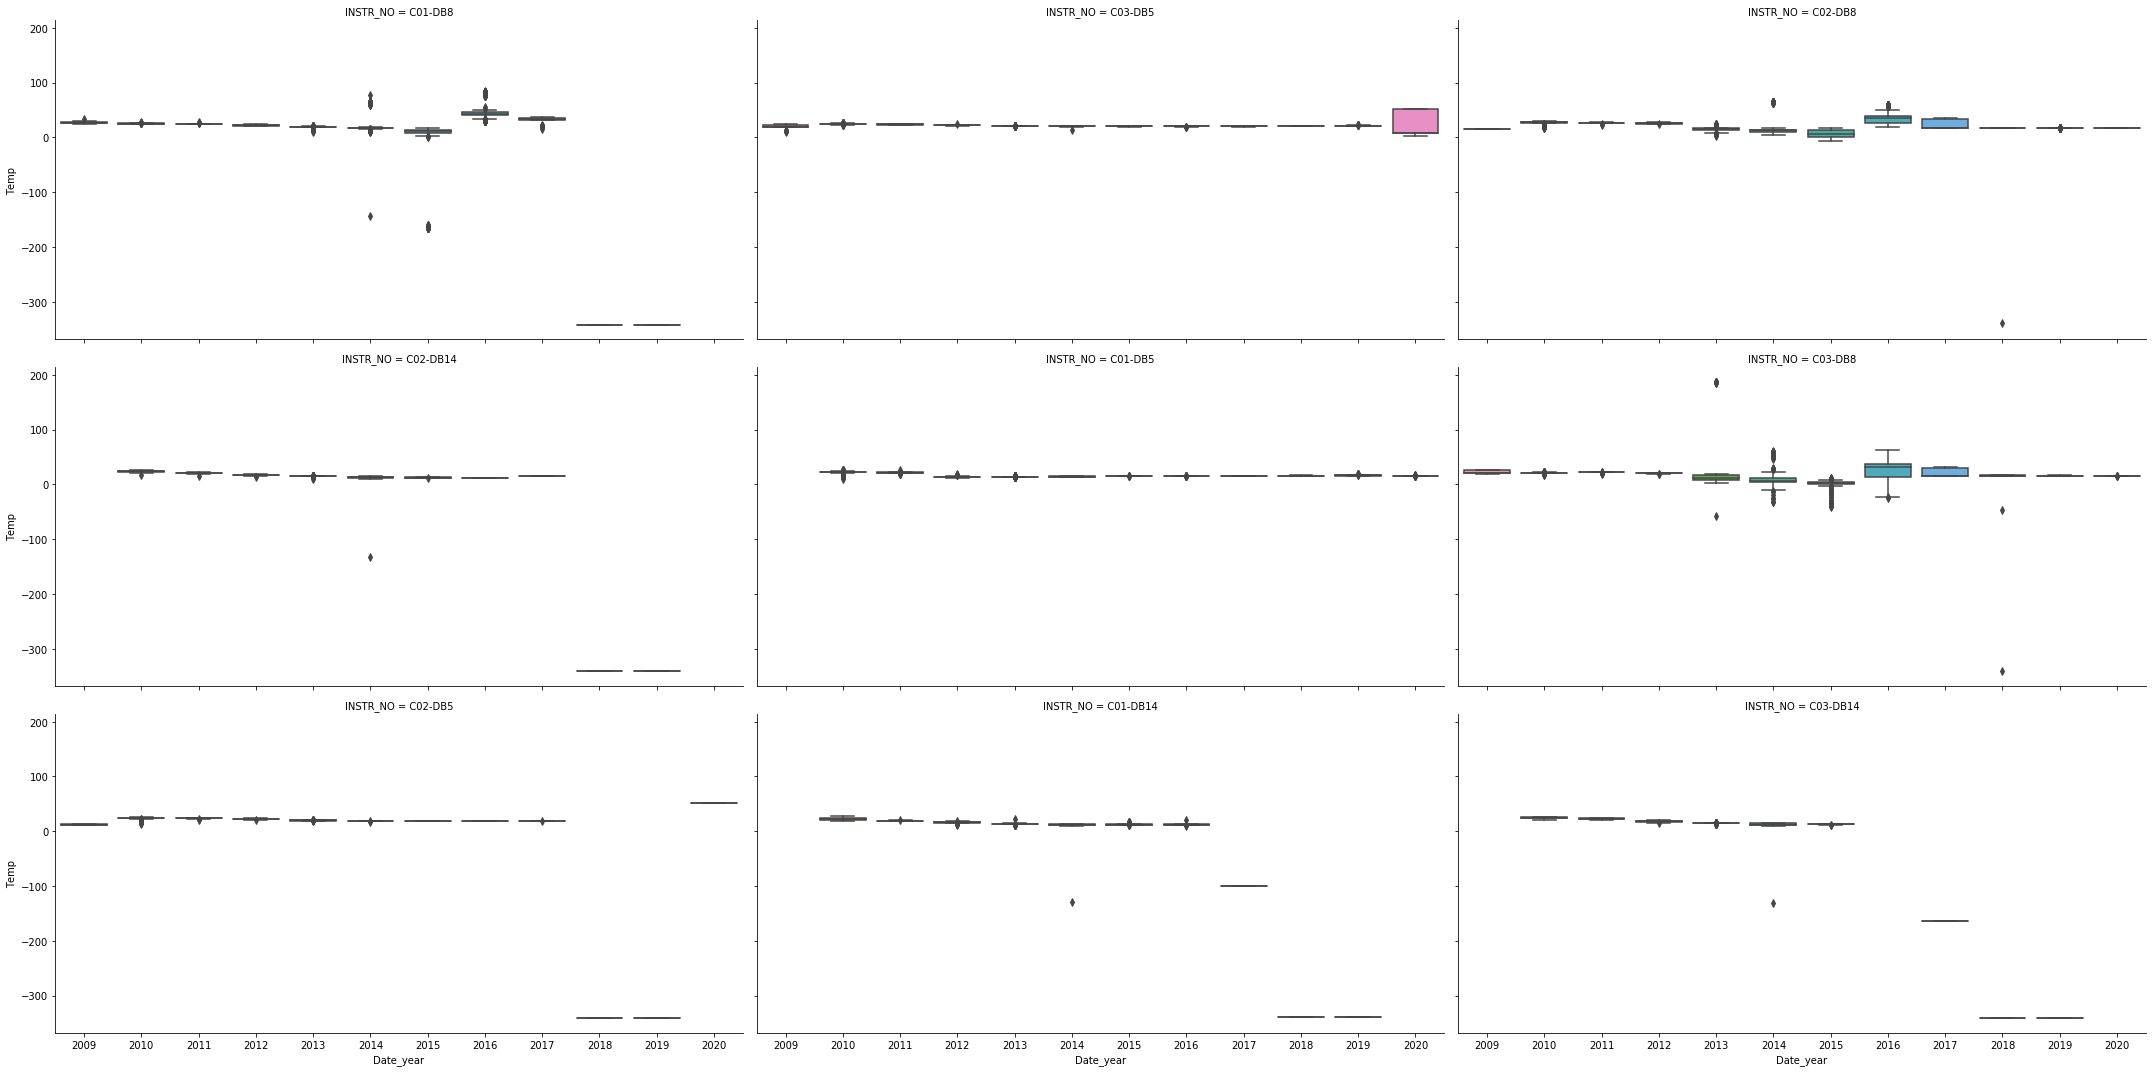

In [53]:
print('Temperature with outliers')
g = sns.catplot(x = 'Date_year', y = 'Temp', col = 'INSTR_NO',col_wrap = 3, data = df,
            kind = 'box',
           height = 5, aspect = 2/1)
#g.set(ylim=(-20, 20))

Temperature with outliers


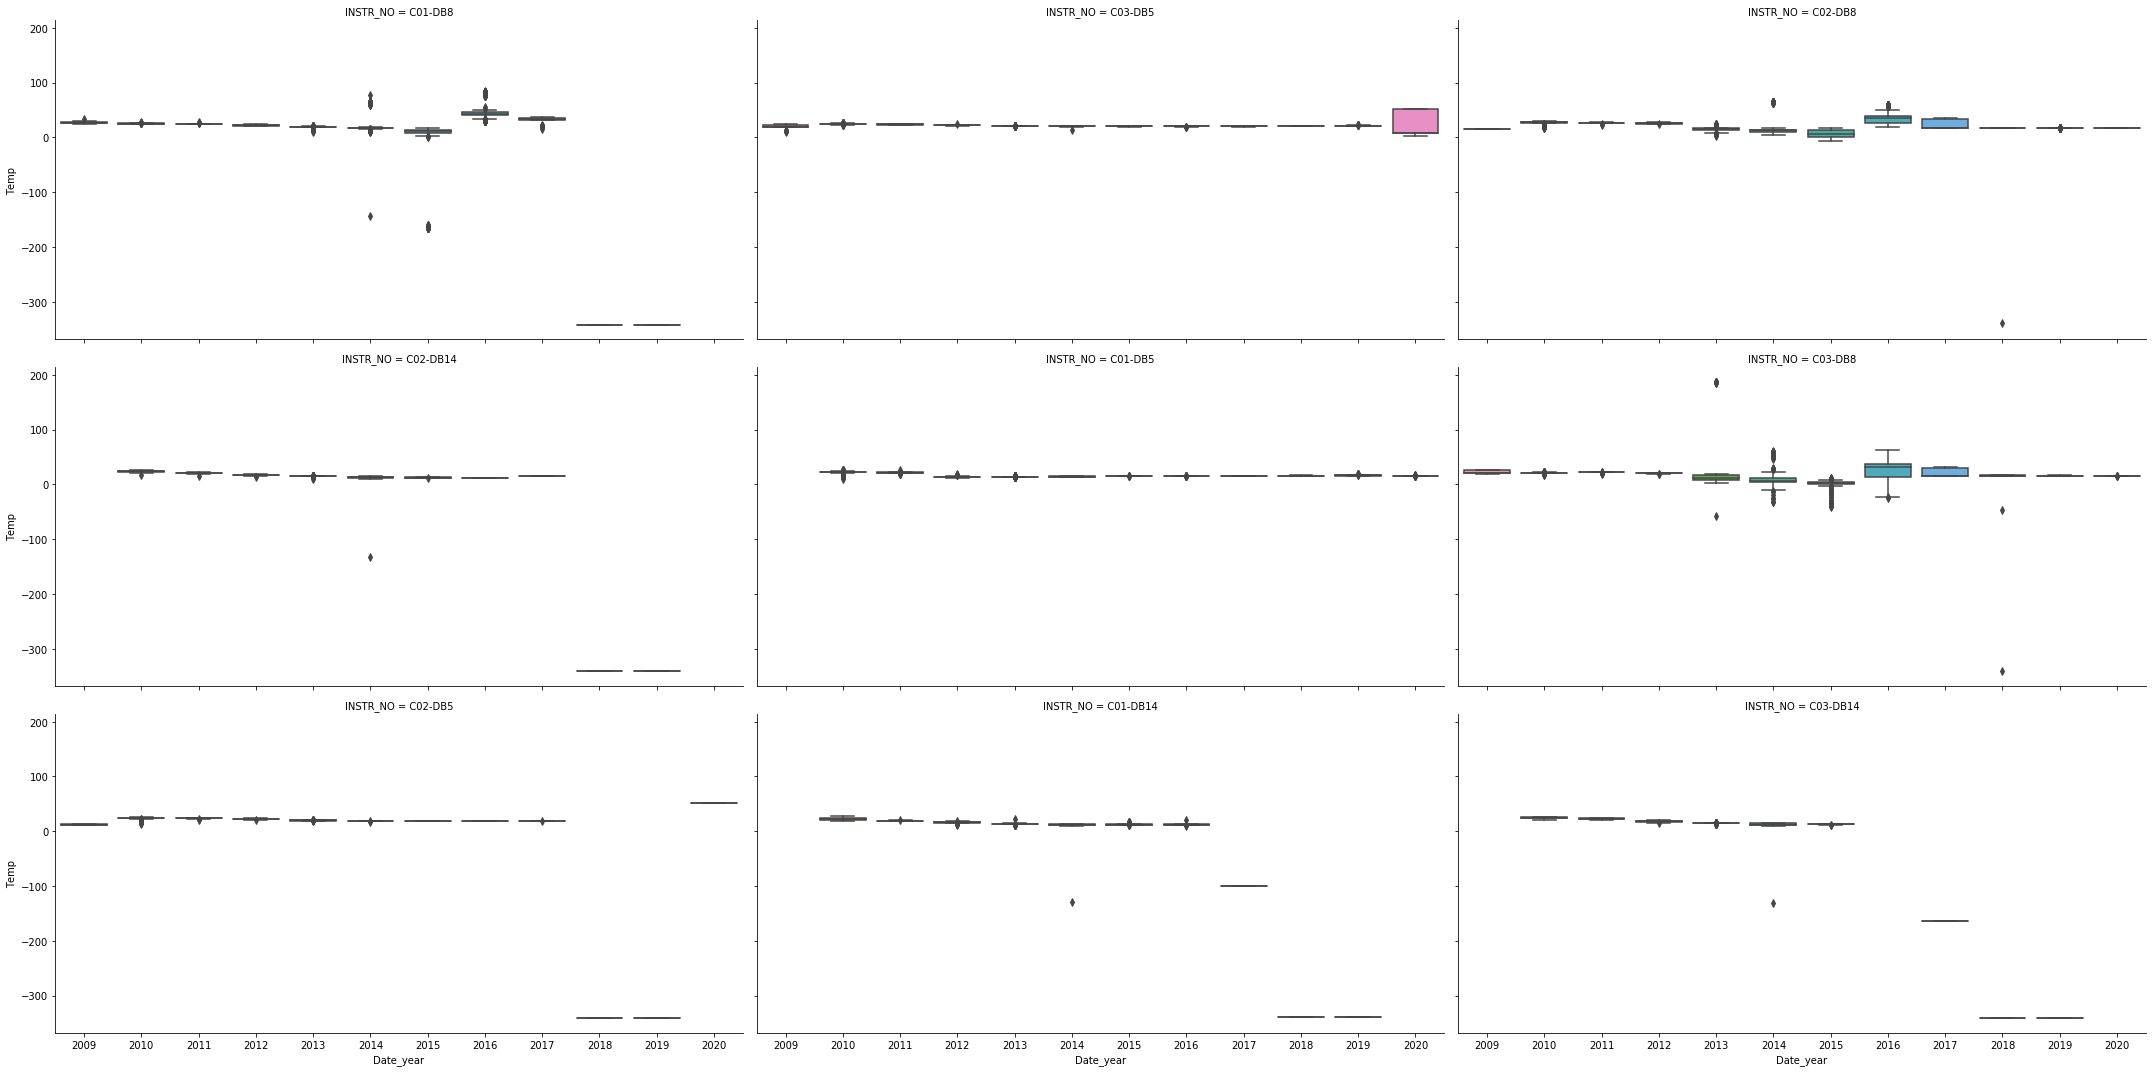

In [54]:
print('Temperature with outliers')
g = sns.catplot(x = 'Date_year', y = 'Temp', col = 'INSTR_NO',col_wrap = 3, data = df,
            kind = 'box',
           height = 5, aspect = 2/1)
#g.set(ylim=(-100, 100))

In [57]:
group_dict = df.groupby('INSTR_NO')[['Reading', 'Temp_reading', 'Stress', 'Temp']].groups

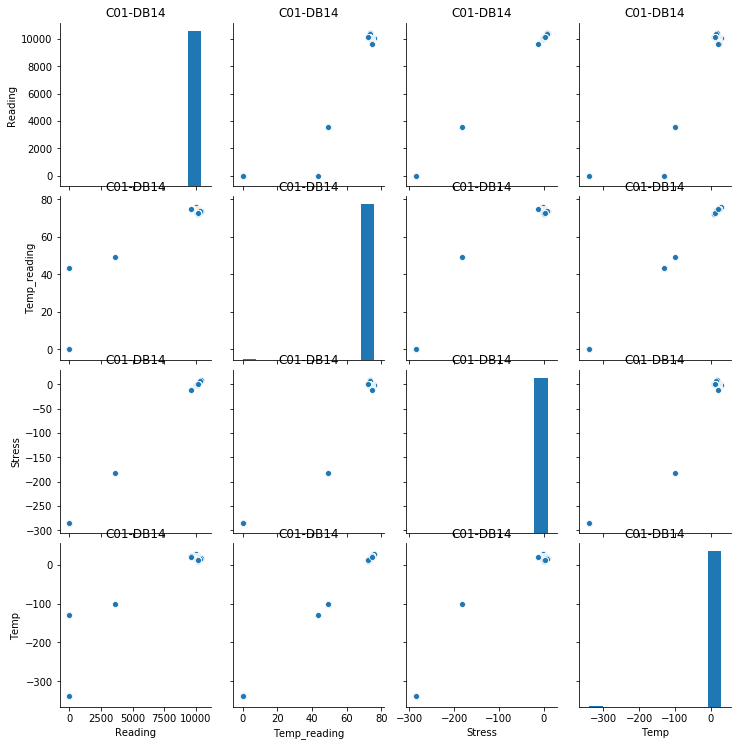

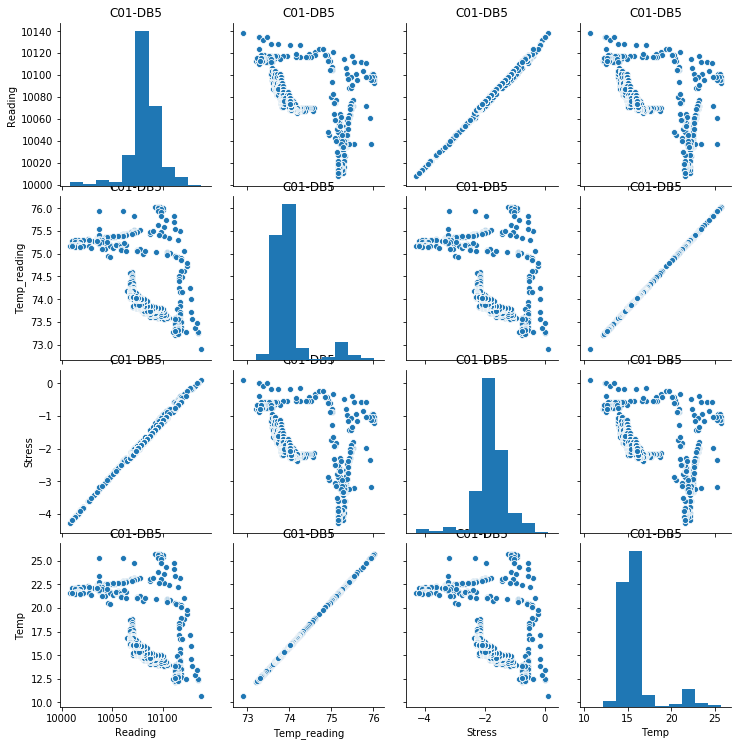

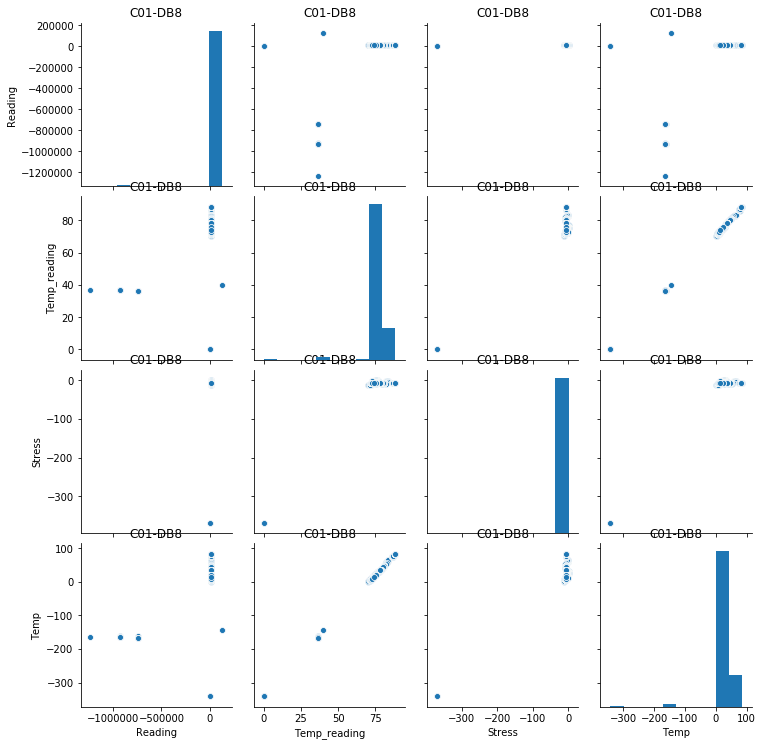

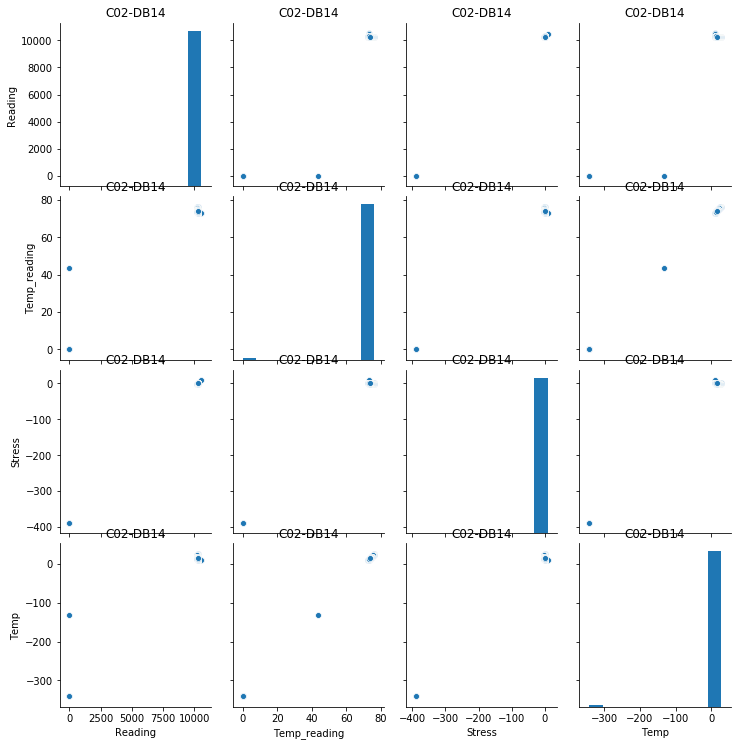

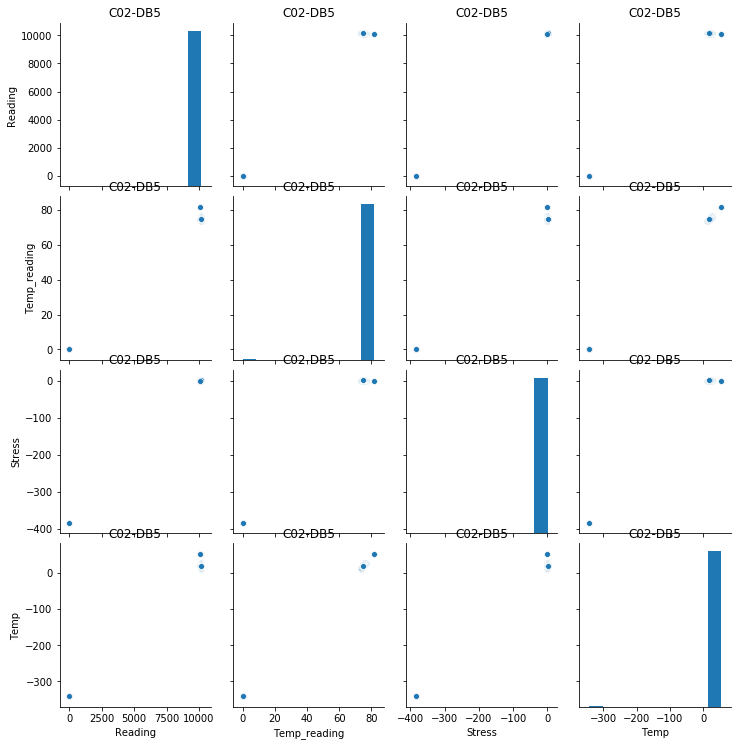

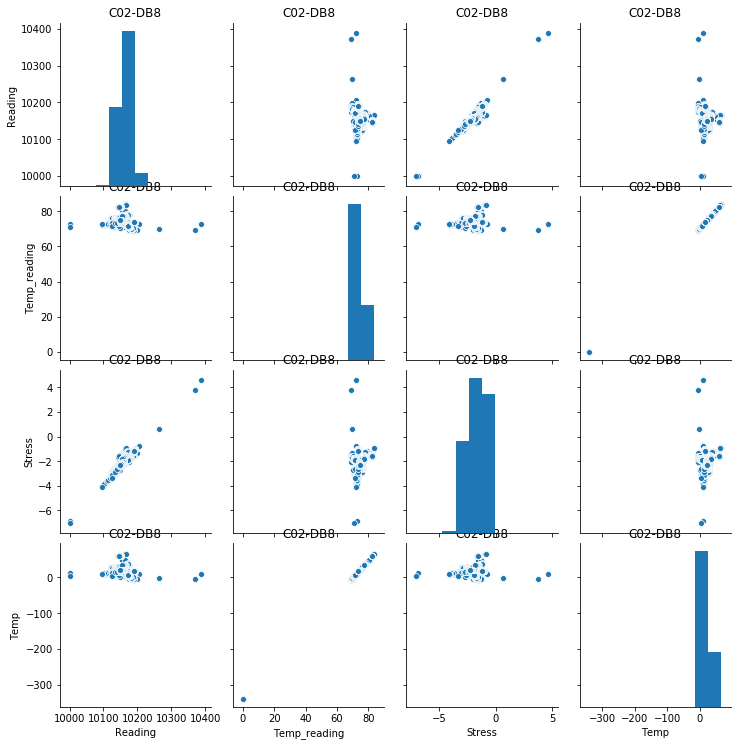

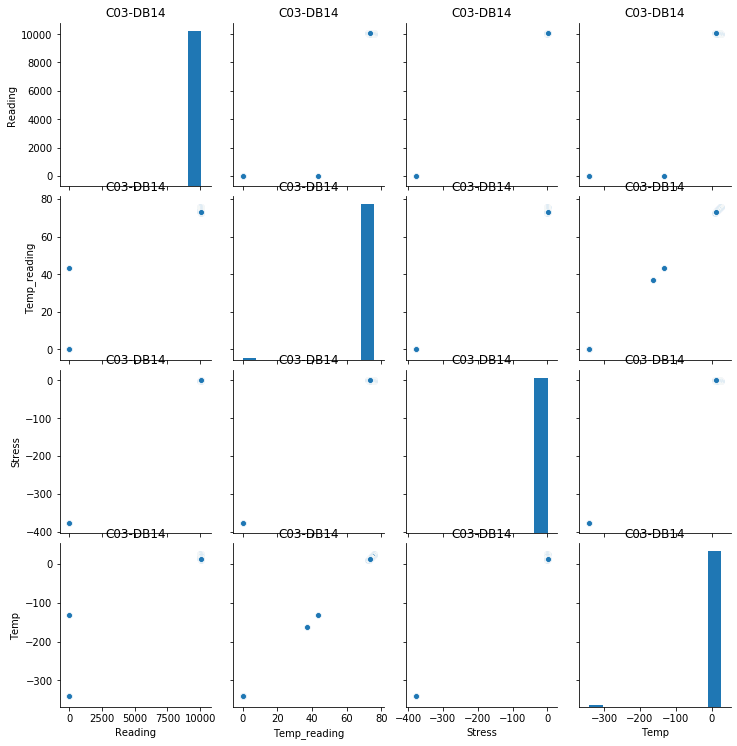

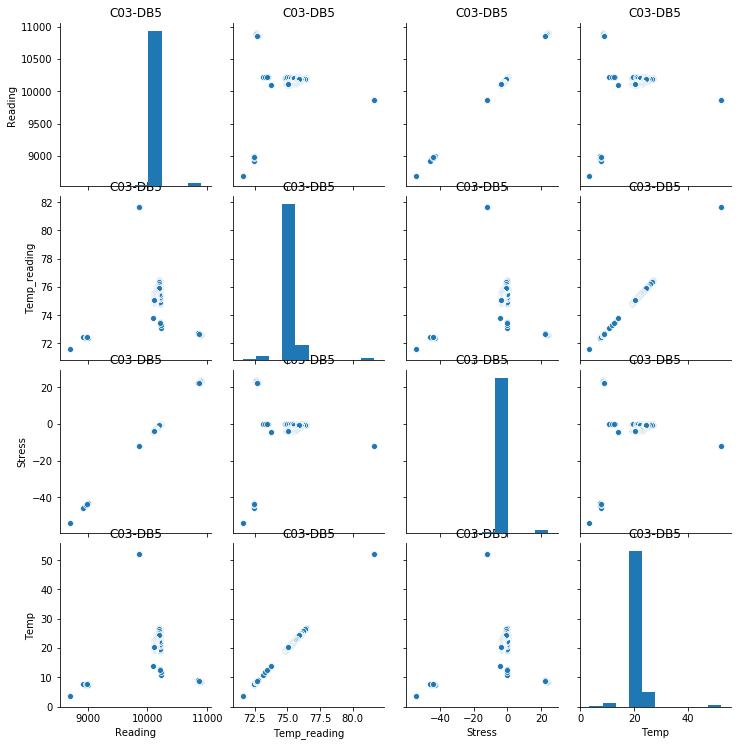

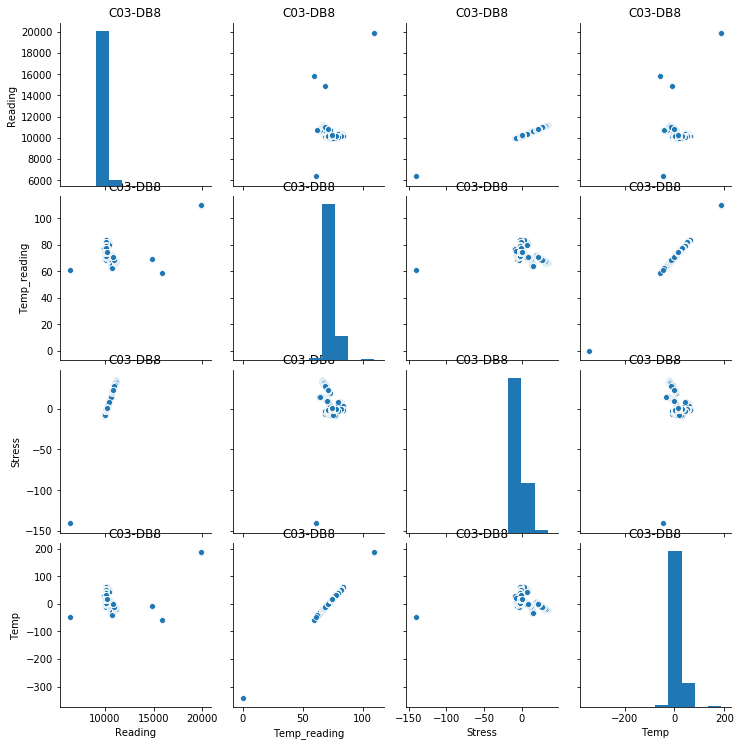

In [58]:
for key in group_dict.keys():
    g = sns.pairplot(df.loc[group_dict[key],['Reading', 'Temp_reading', 'Stress', 'Temp']])
    g.set(title = key)